In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from plotting import plot_utils, load_fits
from utils import roi_utils, default_paths
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type1 = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type1, n_from_end=0, \
                                  verbose=False) for ss in subjects]

fitting_type2 = 'gabor_solo_ridge_12ori_8sf_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]

fitting_type3 = 'gabor_solo_ridge_12ori_8sf_from_residuals'
out_resid = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type3, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]

fitting_type4 = 'gabor_solo_ridge_12ori_8sf_from_residuals_permutation_test'
out_resid_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type4, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

#### Process results of permutation test, compute p-values

In [3]:
from utils import stats_utils
from plotting import summary_plots

p_voxels_orig = [[] for si in range(n_subjects)]
p_voxels_resid = [[] for si in range(n_subjects)]

p_rois_orig = np.zeros((n_subjects, n_rois))
p_rois_resid = np.zeros((n_subjects, n_rois))

propvox_orig = np.zeros((n_subjects, n_rois))
propvox_resid = np.zeros((n_subjects, n_rois))

for si in range(n_subjects):

    # stats for single voxels
    r2_real_orig = out[si]['val_r2']
    r2_shuff_orig = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_orig = np.mean(r2_real_orig[:,0,None]<=r2_shuff_orig[:,0,:], axis=1)
    _,pvals_fdr_orig = stats_utils.fdr_keepshape(p_orig, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_orig[si] = pvals_fdr_orig
    
    # stats for single voxels
    r2_real_resid = out_resid[si]['val_r2']
    r2_shuff_resid = out_resid_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_resid = np.mean(r2_real_resid[:,0,None]<=r2_shuff_resid[:,0,:], axis=1)
    _,pvals_fdr_resid = stats_utils.fdr_keepshape(p_resid, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_resid[si] = pvals_fdr_resid
     
    for rr in range(n_rois):
           
        # for each ROI - how many individual voxels is the model above-chance for?
        # (of those that had reasonable noise ceiling)
        abv_thresh = summary_plots.get_noise_ceiling(out_resid[si])>0.01
        inds = roi_def.ss_roi_defs[si].get_indices(rr) & abv_thresh
            
        propvox_orig[si,rr] = np.mean(pvals_fdr_orig[inds]<0.01)
        propvox_resid[si,rr] = np.mean(pvals_fdr_resid[inds]<0.01)
        
        # is average R2 of the ROI above chance? 
        avg_r2_real = np.mean(r2_real_orig[inds,0], axis=0)
        avg_r2_shuff = np.mean(r2_shuff_orig[inds,0,:], axis=0)
        
        p_rois_orig[si,rr] = np.mean(avg_r2_real<=avg_r2_shuff)
        
        avg_r2_real = np.mean(r2_real_resid[inds,0], axis=0)
        avg_r2_shuff = np.mean(r2_shuff_resid[inds,0,:], axis=0)
        
        p_rois_resid[si,rr] = np.mean(avg_r2_real<=avg_r2_shuff)
        
        
_, p_rois_orig_fdr = stats_utils.fdr_keepshape(p_rois_orig, alpha=0.01, \
                                                       method='poscorr')
_, p_rois_resid_fdr = stats_utils.fdr_keepshape(p_rois_resid, alpha=0.01, \
                                                       method='poscorr')

#### Plot proportion significant voxels

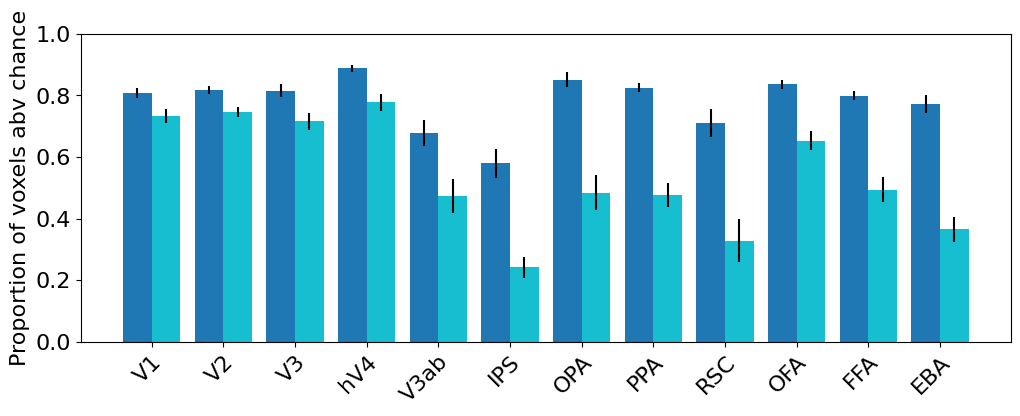

In [4]:
plt.rcParams['pdf.fonttype']=42

ylims = [0, 1.0]

vals = np.concatenate([propvox_orig[:,:,None],propvox_resid[:,:,None]], axis=2)

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                # colors=np.array([[0.8, 0.8, 0.8]]), 
                                space=0.1, \
                xticklabels=roi_names, ylabel='Proportion of voxels abv chance', \
                ylim=ylims, horizontal_line_pos=None,\
                fig_size=(12,4))


#### Threshold voxels by R2
make sure it is always the same set of voxels when comparing across models. 
have to pass threshold for both.

In [7]:
# val_r2_1 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
# val_r2_2 = np.concatenate([out_resid[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
# abv_thresh = (val_r2_1>r2_cutoff) & (val_r2_2>r2_cutoff)

In [6]:
np.mean(abv_thresh)

0.8503915597128562

In [8]:
sig_orig = np.concatenate(p_voxels_orig, axis=0)<0.01
sig_resid = np.concatenate(p_voxels_resid, axis=0)<0.01
abv_thresh = sig_orig & sig_resid

In [9]:
np.mean(abv_thresh)

0.46426724652285173

#### Get info about the Gabor feature space

In [10]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [11]:
feature_corr1 = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr1.shape[0]
allcorr_reshaped1 = np.reshape(feature_corr1, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr1 = np.mean(allcorr_reshaped1, axis=2)
mean_sf_corr1 = np.mean(allcorr_reshaped1, axis=1)

# find maxes across orient/SF.
preferred_ori_corr1 = np.argmax(mean_orient_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_orient_corr1[:,0:1], [1,n_ori])==mean_orient_corr1, axis=1)
assert(not(np.any(is_constant1)))

preferred_sf_corr1 = np.argmax(mean_sf_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_sf_corr1[:,0:1], [1,n_sf])==mean_sf_corr1, axis=1)
assert(not(np.any(is_constant1)))

feature_corr2 = np.concatenate([out_resid[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr2.shape[0]
allcorr_reshaped2 = np.reshape(feature_corr2, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr2 = np.mean(allcorr_reshaped2, axis=2)
mean_sf_corr2 = np.mean(allcorr_reshaped2, axis=1)

preferred_ori_corr2 = np.argmax(mean_orient_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_orient_corr2[:,0:1], [1,n_ori])==mean_orient_corr2, axis=1)
assert(not(np.any(is_constant2)))

preferred_sf_corr2 = np.argmax(mean_sf_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_sf_corr2[:,0:1], [1,n_sf])==mean_sf_corr2, axis=1)
assert(not(np.any(is_constant2)))


In [12]:
n_vox = preferred_ori_corr1.shape[0]
feature_prefs_2dhist_orig = np.zeros((n_vox, n_ori, n_sf))
feature_prefs_2dhist_resid = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr1[vv])
    ff = int(preferred_sf_corr1[vv])
    feature_prefs_2dhist_orig[vv,oo,ff] = 1
    oo = int(preferred_ori_corr2[vv])
    ff = int(preferred_sf_corr2[vv])
    feature_prefs_2dhist_resid[vv,oo,ff] = 1

In [13]:
avg_resp_profiles_orig = np.zeros((n_subjects, n_rois, n_ori, n_sf))
avg_resp_profiles_resid = np.zeros((n_subjects, n_rois, n_ori, n_sf))

for si in range(n_subjects):
    for ri in range(n_rois):        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)   
        avg_resp_profiles_orig[si,ri,:,:] = np.mean(allcorr_reshaped1[inds_this_roi,:,:], axis=0)
        avg_resp_profiles_resid[si,ri,:,:] = np.mean(allcorr_reshaped2[inds_this_roi,:,:], axis=0)

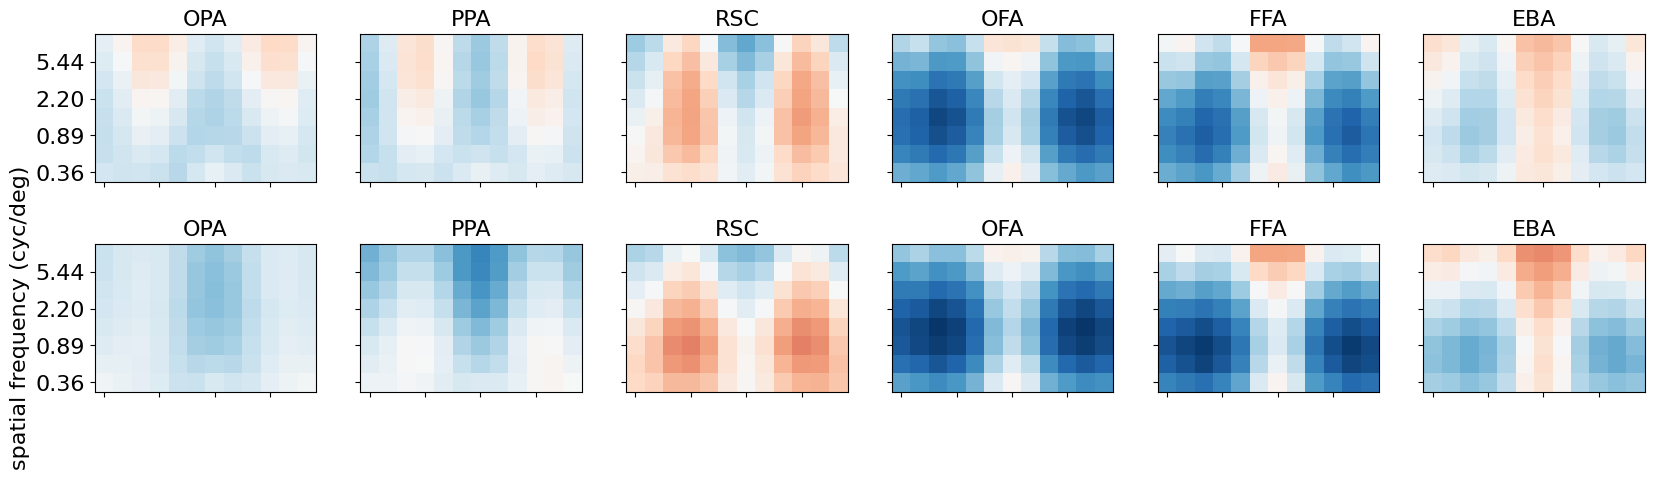

In [17]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,5))
# npy = int(np.ceil(np.sqrt(n_rois)))
# npx = int(np.ceil((n_rois)/npy))

npx = 2
npy = 6;

pi=0

clims = [-0.6, 0.6]

rois_plot = [6,7,8,9,10,11]

for ni, name in enumerate(['orig','resid']):

   
    for ri, rr in enumerate(rois_plot):
    # for rr in range(n_rois):

        pi+=1
        plt.subplot(npx,npy,pi)

#         if ni==2:
            
#             vals = np.mean(avg_resp_profiles_resid[:,rr,:,:], axis=0) - \
#                     np.mean(avg_resp_profiles_orig[:,rr,:,:], axis=0)
            
        if ni==0:
            
            vals = np.mean(avg_resp_profiles_orig[:,rr,:,:], axis=0)
        
        else:
            
            vals = np.mean(avg_resp_profiles_resid[:,rr,:,:], axis=0)
        

        plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

        if ni==2:
            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            plt.xlabel('orientation (deg)')

        else:
            plt.xticks(np.arange(0,12,3)+0.5,[])
            
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if (ri==0):
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            if ni==1:
                plt.ylabel('spatial frequency (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5,[])
        plt.axis('square')
        plt.xlim([0,12])
        plt.ylim([0,8])
        # plt.axis('off')

        # plt.colorbar()

        
        plt.title('%s'%(roi_names[rr]))

    # plt.suptitle(name)


#### for each voxel, how correlated are the estimates of its tuning from two methods?

In [18]:
corr_between_methods = np.array([np.corrcoef(feature_corr1[vv,:], feature_corr2[vv,:])[0,1] \
                                 for vv in range(n_voxels)])

avg_corr_bw_methods = np.zeros((n_rois, n_subjects))
for rr in range(n_rois):
    for ss in range(n_subjects):
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh & (subject_inds==ss)
        avg_corr_bw_methods[rr,ss] = np.mean(corr_between_methods[inds_this_roi])

#### Summary plot of these correlations

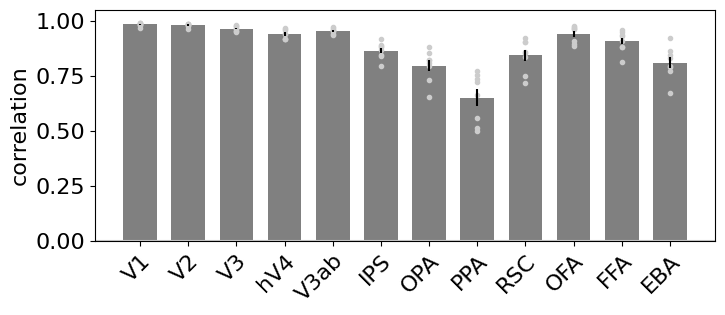

In [19]:
mean_vals = np.mean(avg_corr_bw_methods, axis=1, keepdims=True)
sem_vals = np.std(avg_corr_bw_methods, axis=1, keepdims=True)/np.sqrt(n_subjects)

plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=avg_corr_bw_methods.T[:,:,np.newaxis], 
                                space=0.15, \
                xticklabels=roi_names, ylabel='correlation', \
                ylim=[0.0, 1.05], title='',\
                fig_size=(8,3), \
                colors=np.array([[0.5, 0.5, 0.5]]))

fn2save = os.path.join(default_paths.fig_path, 'Similarity_featuretuning_raw_vs_resid.pdf')
plt.savefig(fn2save)

#### how much did performance drop when regressing out coco-all features?

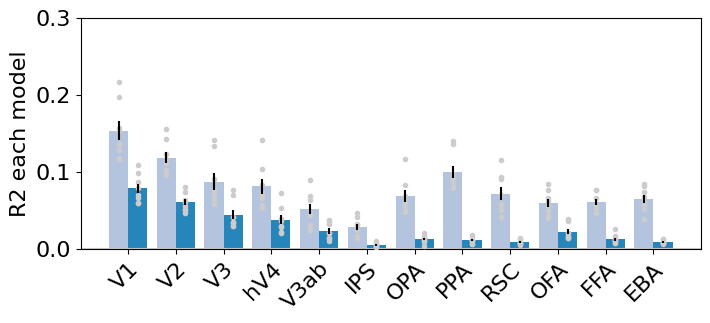

In [20]:
# note this is the average performance over voxels that already passed the threshold of R2. 
avg_r2 = np.zeros((n_subjects, n_rois, 2))
for rr in range(n_rois):
    for ss in range(n_subjects):
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh & (subject_inds==ss)
        avg_r2[ss,rr,0] = np.mean(val_r2_1[inds_this_roi])
        avg_r2[ss,rr,1] = np.mean(val_r2_2[inds_this_roi])

mean_vals = np.mean(avg_r2, axis=0)
sem_vals = np.std(avg_r2, axis=0)/np.sqrt(n_subjects)

colors = cm.PuBu(np.linspace(0,1,4))[1:,:]
plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=avg_r2, 
                                space=0.1, \
                xticklabels=roi_names, ylabel='R2 each model', \
                ylim=[0.0,0.3], title='',\
                colors=colors,\
                fig_size=(8,3))

fn2save = os.path.join(default_paths.fig_path, 'R2_compare_raw_vs_resid.pdf')
plt.savefig(fn2save)

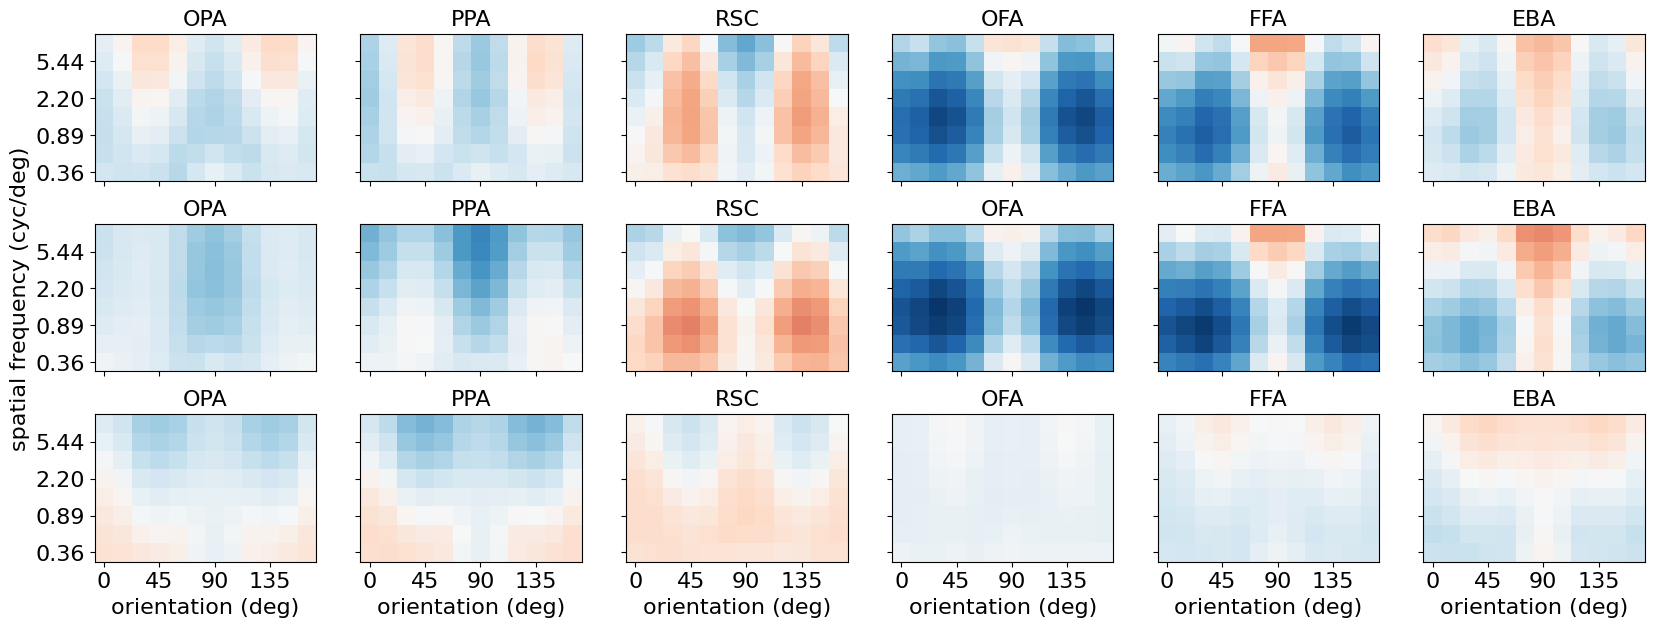

In [15]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,7))
# npy = int(np.ceil(np.sqrt(n_rois)))
# npx = int(np.ceil((n_rois)/npy))

npx = 3
npy = 6;

pi=0

clims = [-0.6, 0.6]

rois_plot = [6,7,8,9,10,11]

for ni, name in enumerate(['orig','resid','resid - orig']):

   
    for ri, rr in enumerate(rois_plot):
    # for rr in range(n_rois):

        pi+=1
        plt.subplot(npx,npy,pi)

        if ni==2:
            
            vals = np.mean(avg_resp_profiles_resid[:,rr,:,:], axis=0) - \
                    np.mean(avg_resp_profiles_orig[:,rr,:,:], axis=0)
            
        elif ni==0:
            
            vals = np.mean(avg_resp_profiles_orig[:,rr,:,:], axis=0)
        
        else:
            
            vals = np.mean(avg_resp_profiles_resid[:,rr,:,:], axis=0)
        

        plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

        if ni==2:
            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            plt.xlabel('orientation (deg)')

        else:
            plt.xticks(np.arange(0,12,3)+0.5,[])
            
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if (ri==0):
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            if ni==1:
                plt.ylabel('spatial frequency (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5,[])
        plt.axis('square')
        plt.xlim([0,12])
        plt.ylim([0,8])
        # plt.axis('off')

        # plt.colorbar()

        
        plt.title('%s'%(roi_names[rr]))

    # plt.suptitle(name)


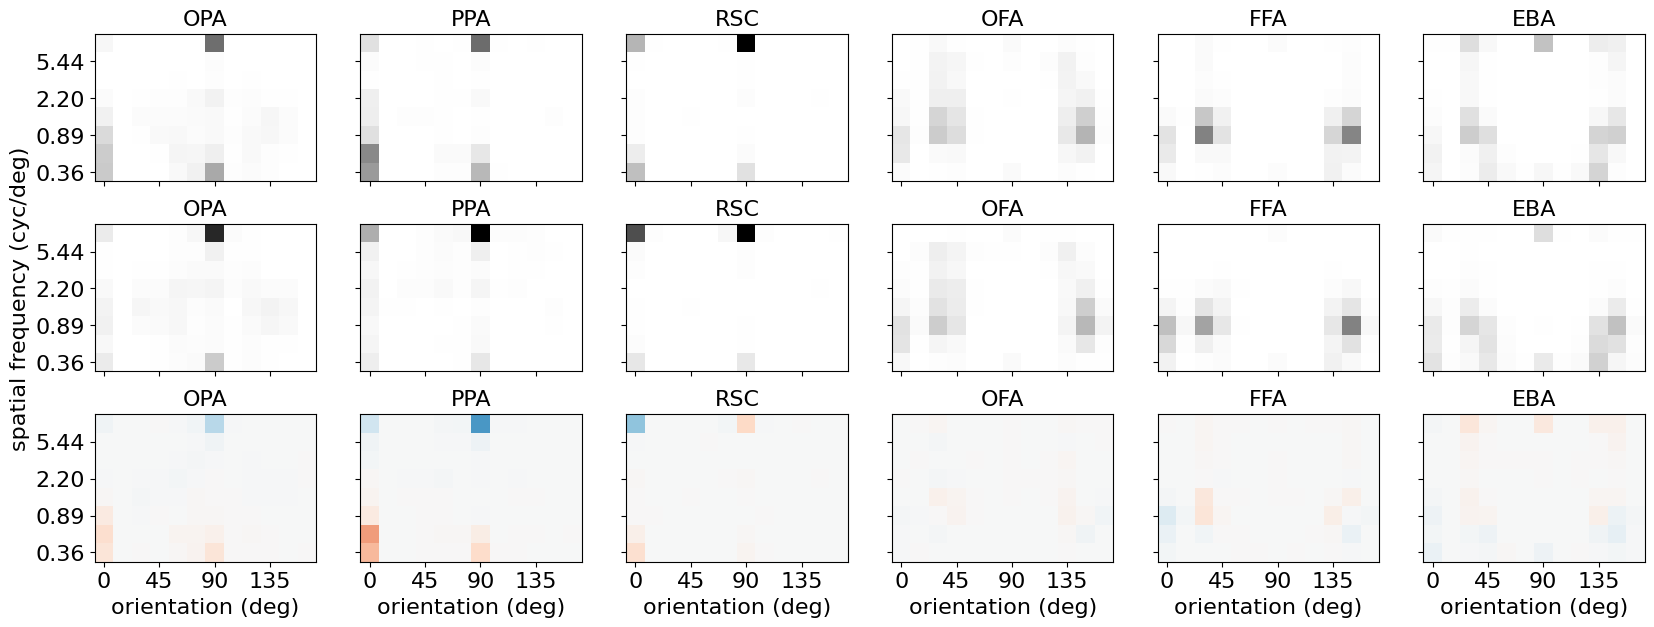

In [16]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,7))
# npy = int(np.ceil(np.sqrt(n_rois)))
# npx = int(np.ceil((n_rois)/npy))

npx = 3
npy = 6;

pi=0


rois_plot = [6,7,8,9,10,11]

for ni, name in enumerate(['orig','resid','resid - orig']):

   
    for ri, rr in enumerate(rois_plot):
        
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh
    
        pi+=1
        plt.subplot(npx,npy,pi)

        if ni==2:
            
            vals1 = np.mean(feature_prefs_2dhist_orig[inds_this_roi,:,:], axis=0)
            vals2 = np.mean(feature_prefs_2dhist_resid[inds_this_roi,:,:], axis=0)
            vals = vals2 - vals1
            clims = [-0.4, 0.4]
            cmap = 'RdBu'

            
        elif ni==0:
            
            vals = np.mean(feature_prefs_2dhist_orig[inds_this_roi,:,:], axis=0)
            clims = [0, 0.4]
            cmap = 'gray_r'
            
        else:
            
            vals = np.mean(feature_prefs_2dhist_resid[inds_this_roi,:,:], axis=0)
            clims = [0, 0.4]
            cmap = 'gray_r'

        plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cmap)

        if ni==2:
            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            plt.xlabel('orientation (deg)')

        else:
            plt.xticks(np.arange(0,12,3)+0.5,[])
            
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if (ri==0):
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            if ni==1:
                plt.ylabel('spatial frequency (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5,[])
        plt.axis('square')
        plt.xlim([0,12])
        plt.ylim([0,8])
        # plt.axis('off')

        # plt.colorbar()

        
        plt.title('%s'%(roi_names[rr]))

    # plt.suptitle(name)
